# Movie Genre Prediction Model

## ETL

### Set up

Loading Packages for Web Scraping, Data Wrangling and NLP

In [1]:
import numpy as np
import pandas as pd
import bs4
import requests
import time
# import string
import re

import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()

### Web Scraping

#### Web Scraping 1

Scraping Wiki page for list of movies from 1999 - 2005

In [2]:
# Year form 1999 - 2005
year = range(1999,2006)

# Empty Data frame to populate super table
super_table = pd.DataFrame()
for y in year:
    # Wikipedia Web Page List of movies for each year
    url = "https://en.wikipedia.org/wiki/List_of_American_films_of_" + str(y)
    # Random sleep time to avoid IP getting blocked
    time.sleep(np.random.randint(0, 10, 1)[0])
    # Manual Parsing HTML page
    request = requests.get(url)
    soup = bs4.BeautifulSoup(request.text,'html.parser')
    # reading movie list table from the web page for each year
    df_sup = pd.read_html(url, attrs = {'class': 'wikitable sortable'},  flavor='bs4', thousands ='.')[0]
    # Assigning Year
    df_sup['Year'] = y
    
    # For scraping URLs for each movie page in Wikipedia
    rows = soup.find("table", class_='wikitable sortable').tbody.find_all('tr')
    link = []
    
    for row in rows:
        cols = row.find_all('td')
        if cols != []:
            try:
                # populating the wikipedia URLs for each movie in the particular Year's movie list table
                link.append("https://en.wikipedia.org" + cols[0].find_all('a')[0].get('href')) 
            except:
                link.append("error") 
        
    df_sup["url"] = link
    
    # Populating the super table by appending each year's table
    super_table = super_table.append(df_sup,  ignore_index=True)

# Exporting
super_table.to_csv("super_table_url.csv")
# super_table = pd.read_csv("super_table_url.csv")

In [3]:
# super_table = pd.read_csv("super_table_url.csv")
cols_list = ['Title', 'Director', 'Cast', 'Genre', 'Year', 'url']
print(super_table.columns)

# Coalescing multiple column with same data into one
super_table['Cast'] = (super_table['Cast (Subject of documentary)']
                       .combine_first(super_table['Cast'])
                       .combine_first(super_table['Cast(Subject of documentary)'])
                       .combine_first(super_table['Cast and crew']))

# Removing false URLs
super_table = super_table[super_table['url'] != "error"][cols_list].reset_index()

Index(['Unnamed: 0', 'Title', 'Director', 'Cast (Subject of documentary)',
       'Genre', 'Notes', 'Year', 'url', 'Cast', 'Cast(Subject of documentary)',
       'Opening', 'Opening.1', 'Production company', 'Cast and crew', 'Ref.'],
      dtype='object')


#### Web Scraping 2
Scraping each movie's Wikipedia Web Page for its text (paragraph content and storing it in the Text column in the super table. Will take around 4-5 hours to complete the scraping.

In [4]:
# For each URL
for i in range(len(super_table)):
    try:
        # Random sleep time
        time.sleep(np.random.randint(0, 10, 1)[0])
        # Manual Parsing
        request_p = requests.get(super_table.loc[i, "url"])
        soup_p = bs4.BeautifulSoup(request_p.text,'html.parser')
        # Scrape the p-tag texts abnd join them together
        super_table.loc[i, "Text"] = ''.join([x.text for x  in soup_p.find_all("p")])
    except:
        # In case of error, continue
        continue


In [5]:
# Exporting the result
super_table.to_csv("super_table_text.csv")
# super_table = pd.read_csv("super_table_text.csv")

#### Data Wrangling


Normalising Genre: First we need to reduce the multiple genre values for a single movie to one. Here most of the first genre in multiple genre use-cases, is Comedy. So we extracting the second value as its Genre.

In [6]:
def genre_extract(gen_list):
    if len(gen_list) >= 2:
        return gen_list[1]
    else:
        return gen_list[0]
    
# Removing Null values 
super_table_text = super_table[(super_table['Text'].notnull() & super_table['Genre'].notnull())].head(1000).reset_index()

# Genre reduction
super_table_text['Genre'] = super_table_text['Genre'].str.split(",").map(genre_extract)

# Null Check
super_table_text.isna().sum()


index         0
Unnamed: 0    0
Title         0
Director      1
Cast          8
Genre         0
Year          0
url           0
Text          0
dtype: int64

Second, we need to map the different Genres to the desired Genre values. For that we manually need to allocate the different Genre values to the desired Genre Categories. This can be subjective.

In [7]:
# set(super_table_text['Genre'])

# Desired Genre Categories
genres = ['Romance','Action','Suspense','Horror','Science Fiction','Others']

# Mapping Genres - Desired Genres as keys and the dataset genres in a list as values.
gen_dict ={'Action': [' Adventure', ' War', 'Action', 'Action Comedy', 'Action comedy', 'Adventure', 
                      'Spy action', 'Superhero', 'Superhero Comedy', 'War', 'War drama'],
           'Horror': [' Horror', ' horror', 'Horror', 'Horror Comedy', 'Horror comedy'],
           'Romance': [' Romance', 'Rom com', 'Romance', 'Romantic Comedy', 'Romantic comedy', 'Romantic drama'],
           'Science Fiction': [' Science Fiction', ' Science fiction', ' sci-fi', 'Science fiction', 
                               'Science fiction Thriller', 'Science-fiction'],
           'Suspense': [' Crime', ' Sport', ' Sports', ' Thriller', ' crime', ' thriller', 'Crime', 
                        'Crime Comedy', 'Crime comedy', 'Crime drama', 'Suspense', 'Thriller']}

# 'Others': [' Animated', ' Animation', ' Biography', ' Biopic', ' Comedy', ' Drama',' Experimental',
#           ' Family', ' Fantasy', ' Musical', ' Mystery', ' Western', ' drama', ' family', ' musical',
#           'Animated', 'Animation', 'Animation Comedy Family', 'Biography', 'Biopic', "Children's film",
#           'Comedy', 'Comedy-Drama', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Historical Drama',
#           'Historical drama', 'Independent', 'Mockumentary', 'Musical', 'Musical comedy', 'Musical drama',
#           'Parody', 'Performance Film', 'Reality', 'Rockumentary', 'Satire', 'Shakespearean', 'Space opera',
#           'Teen comedy', 'Western', 'fantasy', 'parody']


for i in range(1000):
    flag = 0
    for key, val in gen_dict.items():
        # If the Genre value belongs to the value list in the Genre dictionary, assign the key as its Genre.
        if super_table_text.loc[i, 'Genre'] in val:
            super_table_text.loc[i, 'Genre'] = key
            flag = 1
            break
    if flag == 0:
        super_table_text.loc[i, 'Genre'] = 'Others'
            
# Distinct check
print(set(super_table_text['Genre']))
# Null Check
print(super_table_text.isna().sum())
            

{'Horror', 'Others', 'Action', 'Science Fiction', 'Suspense', 'Romance'}
index         0
Unnamed: 0    0
Title         0
Director      1
Cast          8
Genre         0
Year          0
url           0
Text          0
dtype: int64


### Visualisation

                 Title
Genre                 
Action              78
Horror              64
Others             618
Romance             57
Science Fiction     48
Suspense           135


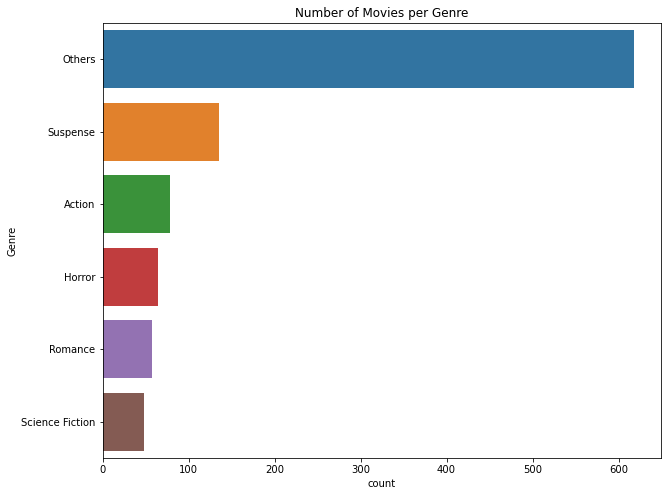

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Count of Movies in each Genres
print(super_table_text[['Title','Genre']].groupby('Genre').count())

# Visualising the Count
plt.figure(figsize=(10, 8))
sns.countplot(y = 'Genre', data = super_table_text, order = super_table_text['Genre'].value_counts().index)
plt.title('Number of Movies per Genre')
plt.ylabel('Genre')
plt.show()

In [9]:
# The Data is unevenly biased towards the 'Others' Genre. So inorder to normalise we have to reduce the 'Others' Genres data.
super_table_norm = (super_table_text[(super_table_text['Genre'] != 'Others') & (super_table_text['Genre'] != 'Suspense')]
                    .append(super_table_text[super_table_text['Genre'] == 'Others']
                            .reset_index()
                            .sample(n = 70))
                   .append(super_table_text[super_table_text['Genre'] == 'Suspense']
                            .reset_index()
                            .sample(n = 70)))

cols_list = ['Title', 'Director', 'Cast', 'Genre', 'Year', 'url']
cols_list.extend(['Text'])
super_table_norm = super_table_norm[cols_list].reset_index()


                 Title
Genre                 
Action              78
Horror              64
Others              70
Romance             57
Science Fiction     48
Suspense            70


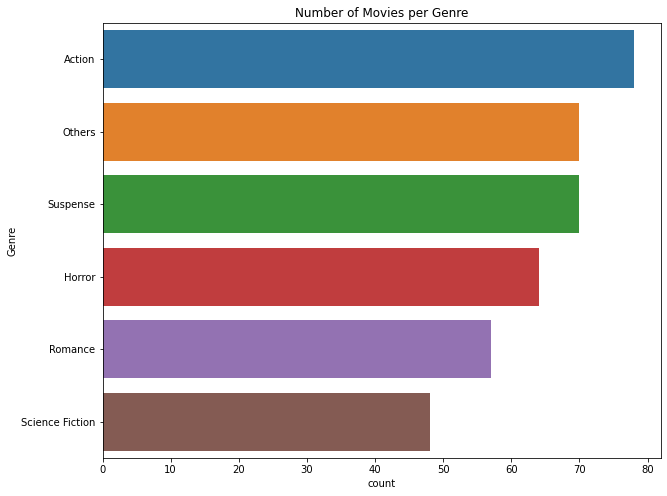

In [10]:
# Count of Movies in each Genres
print(super_table_norm[['Title','Genre']].groupby('Genre').count())

# Visualising the Count
plt.figure(figsize=(10, 8))
sns.countplot(y = 'Genre', data = super_table_norm, order = super_table_norm['Genre'].value_counts().index)
plt.title('Number of Movies per Genre')
plt.ylabel('Genre')
plt.show()

## NLP Modelling

First we need to clean the text by removing the stopwords, unnecessary characters and short words, tokenise, lemmatise, etc.

In [11]:
# Assigning English Stopwords
stopwords1 = set(stopwords.words('English'))

# Defining Text analyser
def text_process(mess):
    # Convert to Lower case
    mess = mess.lower()
    # Replace non alphabets by spaces
    tokens = re.sub('[^a-zA-Z]', ' ',mess)
    # Tokenising
    tokens = tokens.split()
    # Taking only words with 4 or more letters
    tokens = [t for t in tokens if len(t) > 3]
    # Lemmatizing
    tokens = [wl.lemmatize(t) for t in tokens]
    # Return as list
    return [word for word in tokens if word not in stopwords1]

In [12]:
# Importing pAckages for Modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# split into train-test datasets
X_train, X_test, y_train, y_test = train_test_split(super_table_norm['Text'], super_table_norm['Genre'], test_size=0.25)


In [13]:
X_train

27     Just a Little Harmless Sex is a 1999 American ...
147    Sweet November is a 2001 American romantic dra...
327    The In Crowd is a 2000 American teen thriller ...
262    \nThe Golden Bowl is a 2000 period romantic dr...
296    \n\nHoles is a 2003 American neo-Western comed...
                             ...                        
72     \nCrouching Tiger, Hidden Dragon (simplified C...
169    Cypher (also known as Brainstorm and Company M...
209    \nThe Transporter (French: Le Transporteur) is...
256    Psycho Beach Party is a 2000 comedy horror fil...
253    Afro-Punk (2003) is a 66-minute documentary fi...
Name: Text, Length: 290, dtype: object

### Logistic Regression

In [14]:
# Pipelining the model
pipeline_lr = Pipeline([
    # Bag of Words Vectorizing
    ('bow_text', CountVectorizer(analyzer=text_process)),  
    # TF-IDF for relevance of words in each Document
    ('tfidf_text', TfidfTransformer()),
    # Logistic Regression Classification Model
    ('model', LogisticRegression()),
])

# Fitting the model
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('bow_text',
                 CountVectorizer(analyzer=<function text_process at 0x00000295A04AC5E0>)),
                ('tfidf_text', TfidfTransformer()),
                ('model', LogisticRegression())])

In [15]:
# Preiction
y_pred_lr = pipeline_lr.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred_lr))
# Confusion Metrics
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)
# Accuracy
print("Accuracy of Logistic Regression Model : ", accuracy_score(y_test, y_pred_lr))

                 precision    recall  f1-score   support

         Action       0.48      0.70      0.57        23
         Horror       0.69      0.53      0.60        17
         Others       0.43      0.67      0.52        18
        Romance       0.57      0.33      0.42        12
Science Fiction       1.00      0.33      0.50         9
       Suspense       0.54      0.39      0.45        18

       accuracy                           0.53        97
      macro avg       0.62      0.49      0.51        97
   weighted avg       0.58      0.53      0.52        97

[[16  0  4  0  0  3]
 [ 2  9  3  0  0  3]
 [ 3  1 12  2  0  0]
 [ 1  0  7  4  0  0]
 [ 4  2  0  0  3  0]
 [ 7  1  2  1  0  7]]
Accuracy of Logistic Regression Model :  0.5257731958762887


### Random Forest

In [16]:
# Pipelining the model
pipeline_rf = Pipeline([
    # Bag of Words Vectorizing
    ('bow_text', CountVectorizer(analyzer=text_process)),  
    # TF-IDF for relevance of words in each Document
    ('tfidf_text', TfidfTransformer()),
    # Random Forest Classification Model
    ('model', RandomForestClassifier()),
])

# Fitting the model
pipeline_rf.fit(X_train,y_train)

Pipeline(steps=[('bow_text',
                 CountVectorizer(analyzer=<function text_process at 0x00000295A04AC5E0>)),
                ('tfidf_text', TfidfTransformer()),
                ('model', RandomForestClassifier())])

In [17]:
# Prediciton
y_pred_rf = pipeline_rf.predict(X_test)
# classification report
print (classification_report(y_test, y_pred_rf))
# confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print (cm_rf)
# Accuracy
print("Accuracy of Random Forest Model : ", accuracy_score(y_test, y_pred_rf))

                 precision    recall  f1-score   support

         Action       0.42      0.43      0.43        23
         Horror       0.82      0.53      0.64        17
         Others       0.32      0.33      0.32        18
        Romance       0.59      0.83      0.69        12
Science Fiction       0.60      0.67      0.63         9
       Suspense       0.44      0.39      0.41        18

       accuracy                           0.49        97
      macro avg       0.53      0.53      0.52        97
   weighted avg       0.51      0.49      0.49        97

[[10  1  5  0  2  5]
 [ 2  9  2  0  1  3]
 [ 4  0  6  7  0  1]
 [ 1  0  1 10  0  0]
 [ 3  0  0  0  6  0]
 [ 4  1  5  0  1  7]]
Accuracy of Random Forest Model :  0.4948453608247423


Both models are not performing good, though Random forest performs a little better. May be it's because of the data, the text we parsed from Wiki pages. We have parsed all texts from the pages. Instead if we scrape only the Introduction and the Plot, it might perform well along with some cross-validation.